<!-- Colour palette: primary dark #512DA8, 
                 primary light #D1C4E9, 
                 primary #673AB7, 
                 accent #009688,
                 text #212121
-->

<h1 style='color: #512DA8'>Research Track 2</h1>
<h2 style='color: #512DA8'>Assignment 1</h2>
<h3 style='color: #512DA8'>User Interface for the third assignment of Research Track 1</h3>

<p style='color: #212121; font-size: 1.3em'>
<b style='font-size: 2em; font-family: cursive'>F</b>irst, I define some important ROS elements: the node, the publishers, and the parameter server.
Before running the notebook, please run the ros launch file "rt2a1.launch"
   
<b style='color: red'>Note: monitor your RAM consumption, because Jupyter Notebook slowly leaks memory and overloads the RAM, crashing the machine it's on. Running %reset -f to clear the variables from memory, interrupting the kernel and refreshing the page are all useful steps to "reset" the RAM consumption.</b>
</p>

In [1]:
%reset -f
%reset -f

In [2]:
%matplotlib notebook
%matplotlib notebook

import rospy
import numpy as np
import os

from jupyros import ros3d
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import tf
from tf.transformations import quaternion_matrix

from geometry_msgs.msg import Point, Twist
from std_msgs.msg import Bool
from actionlib_msgs.msg import GoalID
from move_base_msgs.msg import MoveBaseActionFeedback
from move_base_msgs.msg import MoveBaseActionResult
from nav_msgs.msg import Odometry

from IPython.display import clear_output
from ipywidgets import Layout, Button, Box, GridBox, Output, IntText, IntSlider, interact

rospy.init_node('rt1a3_ui')

# Count the number of goalpoints reached (and not)
goalpoints_total = []
goalpoints_reached = 0
is_goal_inprogress = False

# Publishers
pub_manualdrive = rospy.Publisher('controller_manual', Bool, queue_size = 1)
pub_assisteddrive = rospy.Publisher('controller_assisted', Bool, queue_size = 1)
pub_cancelgoal = rospy.Publisher('move_base/cancel', GoalID, queue_size = 1)
pub_controller_cmd_vel = rospy.Publisher('controller_cmd_vel', Twist, queue_size = 1)

# Subscribers (MOVED TO THE END...)

# Define timeout duration for movement
rospy.set_param('/rt1a3_action_timeout', 5)

# For some reason, the first msg gets ignored, so this fixes the issue
pub_controller_cmd_vel.publish()

<hr>
<p style='color: #212121; font-size: 1.3em'>
<b style='font-size: 2em; font-family: cursive'>H</b>ere, we have the <b>main interface</b>. The driving mode selection buttons are defined, and all subsequent outputs and/or other widgets get redirected to this area. The interface dynamically updates, to avoid spam.<br><br>
Right below the interactive menu, there is some useful information about the robot's current status and its environment, including a 3D visualisation of the robot and its surroundings.
</p>

Previous action cancelled.
Please select a driving mode: 


Box(children=(Button(button_style='info', description='Autonomous Drive', layout=Layout(width='auto'), style=B…

---
Here is a graph of goalpoints reached so far:


<IPython.core.display.Javascript object>


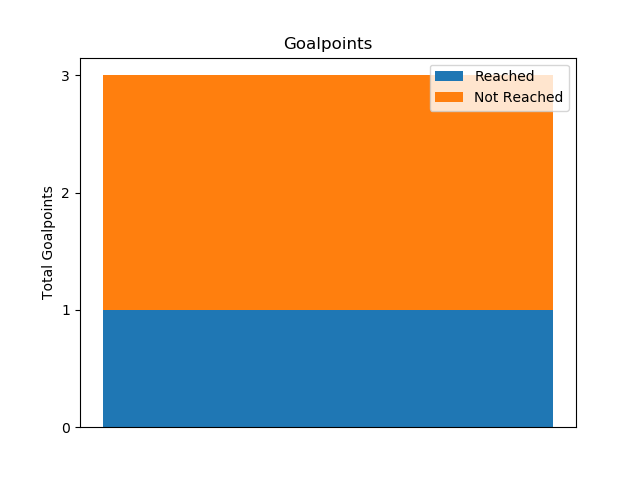

In [3]:
import warnings

with warnings.catch_warnings():
    #warnings.simplefilter('ignore')
    # Mode selection buttons
    buttons_layout = Layout(width = 'auto')
    # To have buttons stacked on top of each other
    button_layout = Layout(display = 'flex',
                          flex_flow = 'column',
                          align_items = 'stretch',
                          width = '100%')
    # To have buttons + 3D map next to each other
    box_layout = Layout(display = 'flex',
                        flex_flow = 'row',
                        align_items = 'stretch',
                        width = '100%')

    b1 = Button(description = 'Autonomous Drive', layout = buttons_layout, button_style = 'info')
    b2 = Button(description = 'Manual Drive', layout = buttons_layout, button_style = 'info')
    b3 = Button(description = 'Assisted Drive', layout = buttons_layout, button_style = 'info')
    button_cancel = Button(description = 'Cancel Goal', button_style = 'danger')
    button_newgoal = Button(description = 'Pick New Goal', button_style = 'success')

    # 3D map
    map_3d = ros3d.Viewer()
    rc = ros3d.ROSConnection(url = 'ws://localhost:9090')
    tf_client = ros3d.TFClient(ros = rc, fixed_frame = 'link_chassis')
    laser_view = ros3d.LaserScan(topic = '/scan', ros = rc, tf_client = tf_client)
    map_view = ros3d.OccupancyGrid(topic = '/map', ros = rc, tf_client = tf_client, continuous = True)
    path = ros3d.Path(topic = '/move_base/NavfnROS/plan', ros = rc,
            tf_client = tf_client)
    urdf = ros3d.URDFModel(ros = rc, tf_client = tf_client,
            path=os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000'))
    g = ros3d.GridModel()
    map_3d.objects = [g, laser_view, map_view, path, urdf]
    map_3d.layout.width = '100%'

    # Output
    print('')
    print('Please select a driving mode: ')
    box_modeselect = Box(children = [b1, b2, b3], layout = button_layout)
    display(box_modeselect)

In [4]:
display(map_3d)

Viewer(layout=Layout(width='100%'), objects=[GridModel(), LaserScan(ros=ROSConnection(url='ws://localhost:9090…

<p style='color: #212121; font-size: 1.3em'>
<b style='font-size: 2em; font-family: cursive'>T</b>he robot's travelled path is displayed below
   
</p>

<IPython.core.display.Javascript object>


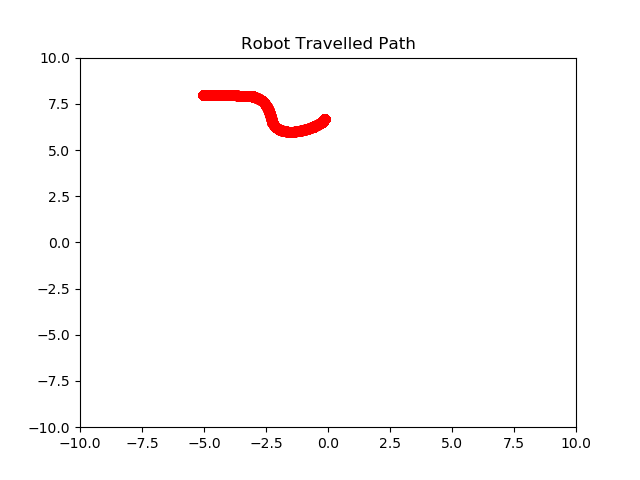

In [5]:
# PLOT: Travelled Path
class VisualiserPath:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [], []

    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln

    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)

    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln

visualiser_path = VisualiserPath()
sub_odom = rospy.Subscriber('/odom', Odometry, visualiser_path.odom_callback)
ani = FuncAnimation(visualiser_path.fig, visualiser_path.update_plot, init_func=visualiser_path.plot_init, blit=True)
plt.title('Robot Travelled Path')
plt.show(block = False)

<p style='color: #212121; font-size: 1.3em'>
<b style='font-size: 2em; font-family: cursive'>H</b>ere, the buttons' behaviours are defined, and communication with the ROS controller node occurs.
</p>

In [6]:
# Autonomous Drive functionality
# Start the autonomous driving
def autonomous_drive(b):
    global goalpoints_reached, goalpoints_total, is_goal_inprogress
    # Hide previous boxes
    clear_output()
    
    is_goal_inprogress = True
    
    target_point = Point(x = coord_x.value, y = coord_y.value)
    pub_goalpoint = rospy.Publisher('user_goalpoints', Point, queue_size = 1, latch = True)
    
    print('Autonomous Drive mode activated')    
    display(button_cancel)
    display(button_newgoal)
    
    pub_goalpoint.publish(target_point)

# Get user input
def autonomous_drive_init(b):
    # Hide mode selection
    clear_output()
    
    global coord_x
    global coord_y
    
    # Get timeout duration from param server for the movement action
    timeout_duration = rospy.get_param('/rt1a3_action_timeout')
    if (timeout_duration == False):
        rospy.logerr('Failed to retrieve action timeout duration from parameter server')
        exit()
    
    # Ask user for coordinates
    coord_x = IntText(value = 0, description = 'X coordinate', 
                      layout = Layout(min_width = '200px', max_width = '20%', width = '20%'))
    coord_y = IntText(value = 0, description = 'Y coordinate', 
                      layout = Layout(min_width = '200px', max_width = '20%', width = '20%'))
    button_submit_coords = Button(description = 'Send Coordinates', button_style = 'info', 
                                  layout = Layout(min_width = '200px', max_width = '20%', width = '20%'))

    print('Target Coordinates')
    display(Box(children = [coord_x, coord_y, button_submit_coords], 
        layout = Layout(display = 'flex', flex_flow = 'column')))

    # Send info to robot
    button_submit_coords.on_click(autonomous_drive)

In [7]:
def manual_drive_init(b):
    # Hide mode selection
    clear_output()
    
    is_drive_manual = Bool(data = True)
    
    print('Manual Drive mode activated.')
    display_manual_control()
    display(button_cancel)
    display(button_newgoal)
    
    pub_manualdrive.publish(is_drive_manual)

In [8]:
def assisted_drive_init(b):
    # Hide mode selection
    clear_output()
    
    is_drive_assisted = Bool(data = True)

    print('Assisted Drive mode activated.')
    display_manual_control()
    display(button_cancel)
    display(button_newgoal)
    
    pub_assisteddrive.publish(is_drive_assisted)

<p style='color: #212121; font-size: 1.3em'>
<b style='font-size: 2em; font-family: cursive'>A</b> generic <i>cancel</i> button is also defined, that cancels any actions and resets the drive mode to nothing. The output window is also cleared, and the mode selection is showed on the interface once more.
</p>

In [9]:
# Cancels the current action and also resets mode.
# is_goal_reached = 0 -> goal not reached
# is_goal_reached = 1 -> goal reached
# is_goal_reached = 2 -> don't count goal
def cancel_action(b, is_goal_reached):
    global goalpoints_reached, goalpoints_total
    
    goal_cancel_ID = GoalID()

    # Cancel action
    pub_cancelgoal.publish(goal_cancel_ID)
    # Reset drive mode
    is_drive_mode = Bool(data = False)
    pub_manualdrive.publish(is_drive_mode)
    pub_assisteddrive.publish(is_drive_mode)
    
    # Reset Display
    print('')
    clear_output()
    
    # Count goalpoints
    if (is_goal_reached == 1):
        print('Goal successfully reached.')
        goalpoints_reached += 1
        goalpoints_total.append(True)
    elif (is_goal_reached == 0):
        print('Goal not reached.')
        goalpoints_total.append(False)
    else:
        print('Previous action cancelled.')
        
    print('Please select a driving mode: ')
    plt.figure(2)
    plt.close()
    display(box_modeselect)
    show_plot_goalpoints() 
    
def cancel_action_init(b):
    global is_goal_inprogress
    is_goal_inprogress = False
    cancel_action(b, 2)

<p style='color: #212121; font-size: 1.3em'>
<b style='font-size: 2em; font-family: cursive'>T</b>he manual drive keypad was created to avoid forcing users to have to go through the terminal with teleop to drive the robot. Ideally, this would all be done with keypress events, but that goes beyond the scope of this demonstration. Also, a joystick/controller can be connected via ipywidgets, if required.<br>
<sub>Some diagonal directional arrows would be nice for the control pad, but the FontAwesome included here is v4.7 which does not contain them, while the ugrade to FontAwesome v5.0 has been done for ipywidgets v8.0 (which does not seem to be available to the public yet)</sub>
</p>

In [10]:
def handler_manual_drive(b):
    direction = b.tooltip
    new_vel = Twist()
    # Check which directional key has been pressed
    if (direction == 'Top Left'):
        new_vel.linear.x = 0.5
        new_vel.angular.z = 1
    if (direction == 'Top'):
        new_vel.linear.x = 0.5
    if (direction == 'Top Right'):
        new_vel.linear.x = 0.5
        new_vel.angular.z = -1
    if (direction == 'Right'):
        new_vel.angular.z = -1
    if (direction == 'Bottom Right'):
        new_vel.linear.x = -0.5
        new_vel.angular.z = 1
    if (direction == 'Bottom'):
        new_vel.linear.x = -0.5
    if (direction == 'Bottom Left'):
        new_vel.linear.x = -0.5
        new_vel.angular.z = -1
    if (direction == 'Left'):
        new_vel.angular.z = 1
    if (direction == 'Stop'):
        new_vel.linear.x = 0
        new_vel.linear.y = 0
        new_vel.linear.z = 0
        new_vel.angular.x = 0
        new_vel.angular.y = 0
        new_vel.angular.z = 0
    
    pub_controller_cmd_vel.publish(new_vel)

In [11]:
def display_manual_control():
    print('')
    print('Manual Robot Velocity Control')
    print('---')

    layout_manual_button = Layout(width = 'auto', height = 'auto')
    layout_manual_control = Layout(width = '100%',
                                   grid_template_columns='80px 80px 80px',
                                   grid_template_rows='80px 80px 80px')

    # Naming: b_md_tl = 'button manual drive top left'
    b_md_tl = Button(layout = layout_manual_button, icon = 'angle-left', tooltip = 'Top Left')
    b_md_t = Button(layout = layout_manual_button, icon = 'chevron-up', tooltip = 'Top')
    b_md_tr = Button(layout = layout_manual_button, icon = 'angle-right', tooltip = 'Top Right')
    b_md_r = Button(layout = layout_manual_button, icon = 'chevron-right', tooltip = 'Right')
    b_md_bl = Button(layout = layout_manual_button, icon = 'angle-left', tooltip = 'Bottom Left')
    b_md_b = Button(layout = layout_manual_button, icon = 'chevron-down', tooltip = 'Bottom')
    b_md_br = Button(layout = layout_manual_button, icon = 'angle-right', tooltip = 'Bottom Right')
    b_md_l = Button(layout = layout_manual_button, icon = 'chevron-left', tooltip = 'Left')
    b_md_stop = Button(layout = layout_manual_button, icon = 'stop', button_style = 'danger', tooltip = 'Stop')

    # Arranging the buttons
    manual_control_box = GridBox(children = [b_md_tl, b_md_t, b_md_tr, b_md_l, b_md_stop, b_md_r, b_md_bl, b_md_b, b_md_br],
                                 layout = layout_manual_control)

    # Binding the buttons
    b_md_tl.on_click(handler_manual_drive)
    b_md_t.on_click(handler_manual_drive)
    b_md_tr.on_click(handler_manual_drive)
    b_md_r.on_click(handler_manual_drive)
    b_md_bl.on_click(handler_manual_drive)
    b_md_b.on_click(handler_manual_drive)
    b_md_br.on_click(handler_manual_drive)
    b_md_l.on_click(handler_manual_drive)
    b_md_stop.on_click(handler_manual_drive)


    # Display to user
    display(manual_control_box)

<p style='color: #212121; font-size: 1.3em'>
<b style='font-size: 2em; font-family: cursive'>T</b>he logic governing the plot for reached/not reached goalpoints is the following. The plot will appear on the main user interface above.
</p>

In [12]:
def show_plot_goalpoints():
    global goalpoints_reached, goalpoints_total
    
    print('---')
    print('Here is a graph of goalpoints reached so far:')
    plt.figure(2)
    plt.hist([goalpoints_total[:goalpoints_reached],goalpoints_total[goalpoints_reached:]], stacked='false',
            bins = 1, rwidth = 1)
    ytick_values = range(0, len(goalpoints_total) + 1)
    plt.xticks([])
    plt.yticks(ytick_values)
    plt.title('Goalpoints')
    plt.ylabel('Total Goalpoints')
    plt.legend(['Reached', 'Not Reached'])
    plt.show()

In [13]:
# Plots the reached/not reached goalpoints
def update_plot_goalpoints(data):    
    global is_goal_inprogress
    # Get robot current position
    pos_x = data.feedback.base_position.pose.position.x
    pos_y = data.feedback.base_position.pose.position.y
    # Goal was chosen by user and is global
    goal_x = coord_x.value
    goal_y = coord_y.value
    
    # Check if target has been reached, with tolerance
    goal_tolerance = 0.5
    if (abs(pos_x - goal_x) <= goal_tolerance and abs(pos_y - goal_y) <= goal_tolerance):
        if (is_goal_inprogress == True):
            clear_output()
            cancel_action('', 1)
            is_goal_inprogress = False
        
# Need this to detect timeout
def callback_result(data):
    global is_goal_inprogress
    if (data.status.status == 2 and is_goal_inprogress == True):
        clear_output()
        cancel_action('', 0)
        is_goal_inprogress = False
    
sub_move_base_feedback = rospy.Subscriber('move_base/feedback', MoveBaseActionFeedback, update_plot_goalpoints)
sub_move_base_status = rospy.Subscriber('move_base/result', MoveBaseActionResult, callback_result)

<p style='color: #212121; font-size: 1.3em'>
<b style='font-size: 2em; font-family: cursive'>F</b>inally, the buttons are bound to their respective event handlers.
</p>

In [14]:
# Binding buttons to functions
b1.on_click(autonomous_drive_init)
b2.on_click(manual_drive_init)
b3.on_click(assisted_drive_init)
button_cancel.on_click(cancel_action_init)
button_newgoal.on_click(cancel_action_init)